## Objetivo
A partir de um sinal de vibração genérico: 

    1. Visualizar o sinal no tempo, seus parâmetros estatísticos e histograma. 
    2. Visualizar o sinal na frequênica, identificando os picos dominantes.
    3. Testar os métodos de extração de características.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# para cronometrar a leitura do csv e do FFT
import time

In [3]:
start_time = time.time()

# reduz o samplig frequency 'ratio' vezes, tomando apenas 1 a cada 'ratio' sinais
ratio = 50
sampling_freq=50000/ratio

# poupa apenas as linhas múltiplas de 'ratio' e lista as demais para exclusão
skip=[i for i in range(0,250000) if i%ratio] 

# lê dados no tempo
signals = pd.read_csv('../mafaulda/imbalance/35g/56.7296.csv', header=None, 
                      names=['tacometro','ax1','rad1','tg1','ax2','rad2','tg2','microfone'],
                      skiprows=skip)

# reordena colunas e nomeia o conjunto das acelerações
signals = signals[['tacometro','microfone','ax1','ax2','rad1','rad2','tg1','tg2']]
accelerations = signals.drop(['tacometro','microfone'], axis=1)

# transformada de Fourrier, converte para valores absolutos 
signals_fft = signals.apply(np.fft.rfft, axis=0, norm="ortho")
signals_fft = signals_fft.apply(np.abs)
# adiciona eixo da frequência
# OBS: a frequência de Nyquist é sampling_freq/2
signals_fft['freq_ax'] = np.linspace(0, sampling_freq/2+1, signals_fft.shape[0])
accelerations_fft = signals_fft.drop(['tacometro', 'microfone'], axis=1)

end_time = time.time()

print("Sinal com shape {} obtido em {} segundos".format(signals.shape, end_time-start_time))
print("a frequência de aquisição foi reduzida de 50kHz para {}kHz\n".format(sampling_freq/1000))
# signals.head()

Sinal com shape (5000, 8) obtido em 0.6767442226409912 segundos
a frequência de aquisição foi reduzida de 50kHz para 1.0kHz



# Análise no tempo

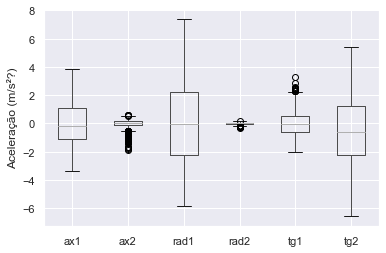

In [4]:
# checa nível dos sinais de aceleração
accelerations.boxplot()
plt.ylabel('Aceleração (m/s²?)')
plt.show()

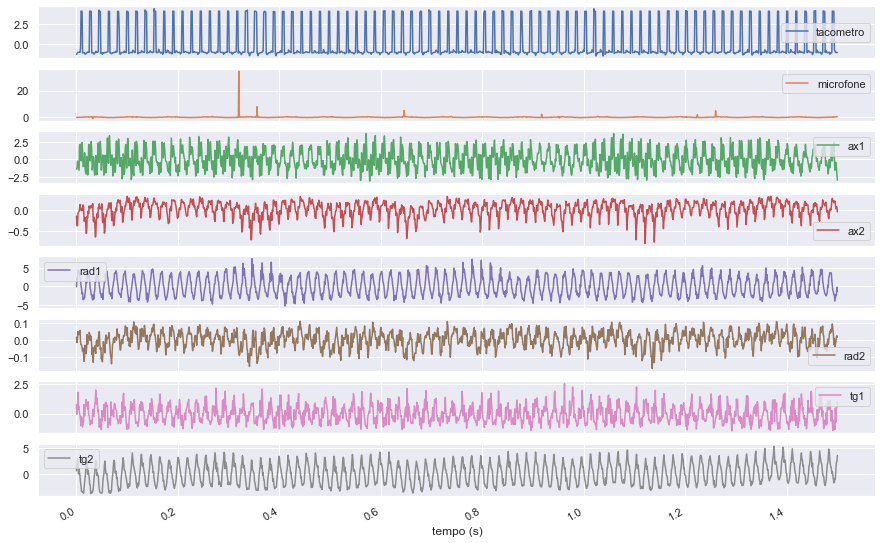

In [5]:
signals['tempo (s)'] = np.linspace(0, 5, signals.shape[0])
signals.loc[:1500].plot(subplots=True, x='tempo (s)', layout=(8,1), figsize=(15,10))
signals.pop('tempo (s)');

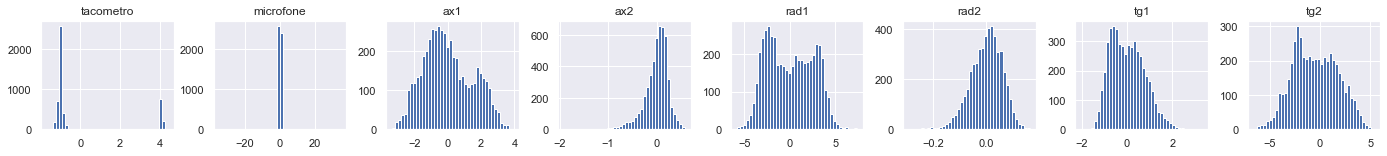

In [6]:
# exibe tabela resumo
# print(pd.DataFrame({'Médias': signals.mean(),
#                     'Medianas': signals.median(),
#                     'Intervalo máximo': signals.max()-signals.min()}), '\n')

# histograma para cada sinal
signals.hist(bins=40, figsize=(24,2), layout=(1,8))
plt.show()

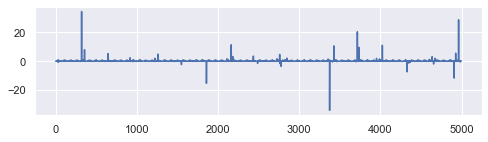

som do microfone


In [7]:
# detalha sinal do microfone no tempo
signals['microfone'].plot(figsize=(8,2))
plt.show()

from IPython.display import Audio, display
print('som do microfone')
display(Audio(signals['microfone'], rate=sampling_freq))

## Dados Estatísticos
### Média, curtose e RMS

In [8]:
# Média
medias = signals.mean().to_dict()
medias = {k+'_mean': v for k,v in medias.items()}

# Curtose
curtoses = signals.kurtosis().to_dict()
curtoses = {k+'_kurt':v for k, v in curtoses.items()}

# RMS
rms = signals.pow(2).sum().pow(1/2).to_dict()
rms = {k+'_rms':v for k, v in rms.items()}

### Entropia

In [9]:
import scipy.stats as stats

# demonstração em um sinal
# # separa o sinal em faixas de 0.2 na sua unidade 
# step = 0.2
# bin_range = np.arange(-10, 10+step, step)
# out  = pd.cut(signals['ac2tg'], bins = bin_range, include_lowest=True, right=False, retbins=True)[0]

# # desta divisão, retira-se a contagem em cada uma das faixas, como em um histograma
# out.value_counts(sort=False).plot.bar()
# stats.entropy(out.value_counts())

# para todos os sinais
step = 0.2
bin_range = np.arange(-10, 10+step, step)

entropias = {}
for i, col in enumerate(signals.columns.values[:]):
    out = pd.cut(signals[col], bins = bin_range, include_lowest=True, right=False, retbins=True)[0]
    entropias[col] = stats.entropy(out.value_counts())

entropias = {k+'_entropy':v for k,v in entropias.items()}

### Combinação dos patâmetros estatísticos

In [10]:
time_statistics = entropias
time_statistics.update(medias)
time_statistics.update(curtoses)
time_statistics.update(rms)

# Análise na frequência

## Fundamental

In [11]:
# dentre os 3 maiores picos na fft do tacometro, deve retornar o de menor frequência
# assim, evita-se o mascaramento da fundamental pelas harmonicas
fundamental_candidates = [0, 0, 0]

for i in range(3):
    index = signals_fft['tacometro'].argmax()
    fundamental_candidates[i] = signals_fft.freq_ax[index]
    for j in range(-2, 3):
        signals_fft.tacometro[index+j] = 0

fundamental = min(fundamental_candidates)
index = signals_fft.index[signals_fft['freq_ax'] == fundamental]


## Hamônicas

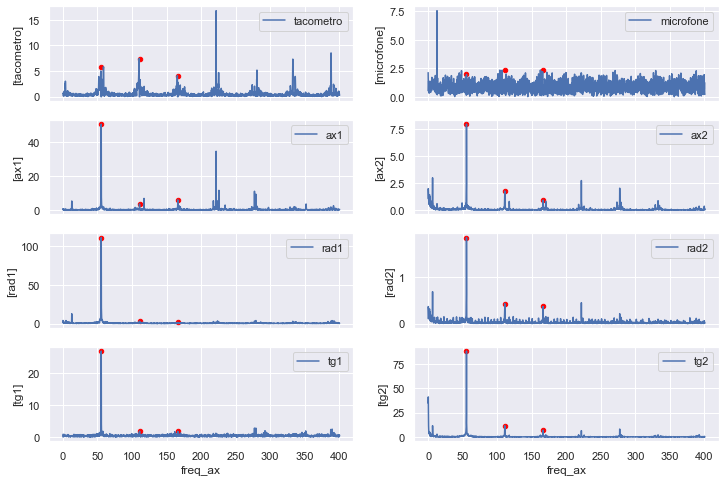

In [12]:
idx = index[0]
harmonic_values = pd.DataFrame(columns = signals_fft.columns)
harmonic_values


for i in range(1,4):
    # resgata no DataFrame os valores na harmonica i
    harmonic_values = harmonic_values.append(signals_fft.iloc[idx*i-25:idx*i+26].max(), ignore_index=True)
    harmonic_values.iloc[-1]['freq_ax'] = fundamental*i
#     harmonic_values = pd.concat([harmonic_values, signals_fft.iloc[idx*i-4:idx*i+5].max()], axis=1)


fig, axes = plt.subplots(4,2,figsize=(12, 8),sharex=True)

for i, col in enumerate(signals_fft.columns.values[:-1]):
    signals_fft[:2000].plot(x='freq_ax', y=[col], ax=axes[i//2,i%2])
    harmonic_values.plot(x='freq_ax', y=[col], ax=axes[i//2,i%2], kind='scatter', color="red")
    
plt.show()

In [13]:
# função implementada na extração de dados

def extract_n_harmonics(fft_df, fund_index, n_harmonics=3):
    #protege o DataFrame original de alterações
    fft_df = fft_df.copy()
    
    # extrai todos os valores nos primeiros n harmônicos, exceto para o tacometro e freq_ax
    fft_df.pop('tacometro')
    fft_df.pop('freq_ax')

    harmonic_features = {}
    idx = fund_index[0]
    for i in range(n_harmonics+1):
        # resgata no DataFrame os valores na harmonica i
        if i:
            harm_values = fft_df.iloc[idx*i-10:idx*i+11].max()
        else:
            harm_values = fft_df.iloc[0]
        harm_values = harm_values.to_dict()
        
        # adiciona às features com o respectivo sulfixo do harmonico i
        harmonic_features.update({k+'_{}h'.format(i): v for k, v in harm_values.items()})

    return harmonic_features

# extract_n_harmonics(signals_fft, index, 3)

# Experimentos

## Análise das velocidades
Componentes de 'corrente contínua', de frequência igual a zero, no sinal da aceleração idicariam que o aquipamento do ensaio possui uma aceleração líquida não nula em uma dada direção. No entanto, o ensaio foi feito sobre báse estática e portanto essa aceleração não é válida e deve ser ignorada.

O sinal de aceleração pode ser integrado para obtenção da velocidade no mesmo eixo. Esta interação, no entanto, acaba exacerbando componentes de baixa frequência. Para evitar a dominação se componentes espúrios de baixa frequência, propõe-se a aplicação de um filtro passa alta depois (ou antes) da integração.

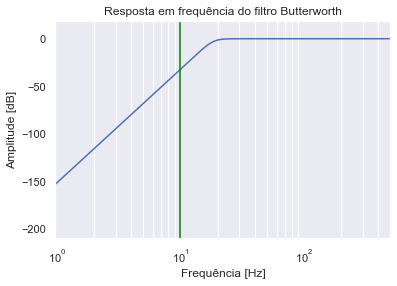

In [99]:
# ilustração do filtro passa alta
from scipy import signal

# define um filtro passa alta arbitrário em 1/3 da fundamental 
b, a = signal.butter(6, fundamental/3, 'highpass', fs=sampling_freq)
w, h = signal.freqz(b, a, fs=sampling_freq)
plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Resposta em frequência do filtro Butterworth')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(10, color='green') # cutoff frequency
plt.show()

In [183]:
from scipy import integrate

# transforna-se o sinal de g para m/s²
accelerations_mmps2 = accelerations*9.80665*1000

# instancia o filtro passa alta
sos = signal.butter(6, 10, 'highpass', fs=sampling_freq, output='sos')

# calcula velocidade pela integral (trapezoidal) dos sinais
velocity_no_filter     = pd.DataFrame()
velocity_filter_before = pd.DataFrame()
filtered_acc           = pd.DataFrame()
velocity_filter_after  = pd.DataFrame()


dt = 1/sampling_freq
for col in accelerations_mmps2.columns:
    velocity_no_filter[col] = integrate.cumtrapz(y=np.array(accelerations_mmps2[col]), dx=dt, initial=0)
    correcao = velocity_no_filter[col].mean()
    velocity_no_filter[col] = velocity_no_filter[col].apply(lambda x: x - correcao)
    
    filtered_acc[col] = signal.sosfilt(sos, accelerations_mmps2[col])
    velocity_filter_before[col] =  integrate.cumtrapz(y=np.array(filtered_acc[col]), dx=dt, initial=0)

    velocity_filter_after[col] = integrate.cumtrapz(y=np.array(accelerations_mmps2[col]), dx=dt, initial=0)
    velocity_filter_after[col] = signal.sosfilt(sos, velocity_filter_after[col])


Nota-se que o sinal não filtrado teve os componentes de baixa frequencia amplificados pela integração.

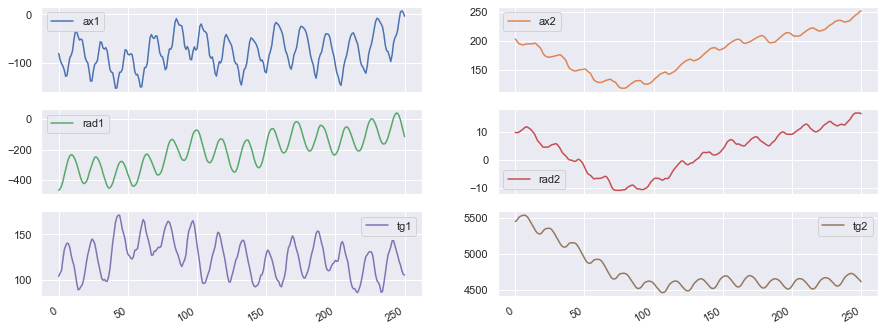

In [184]:
# velocidade NÃO FILTRADA no tempo 
velocity_no_filter.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));

Entre os sinais filtrados faz pouca diferença aplicar o filtro antes ou depois de integrar.

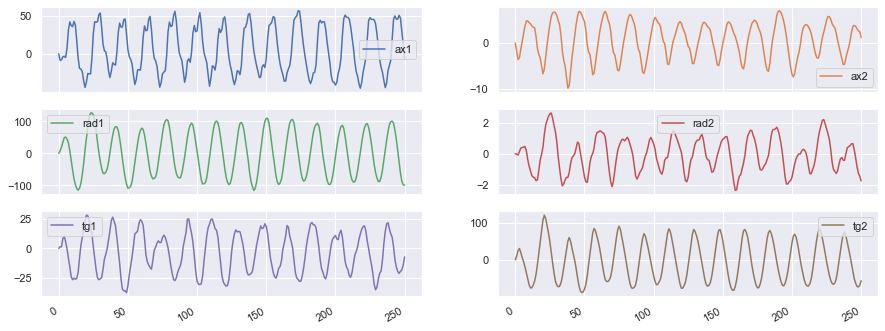

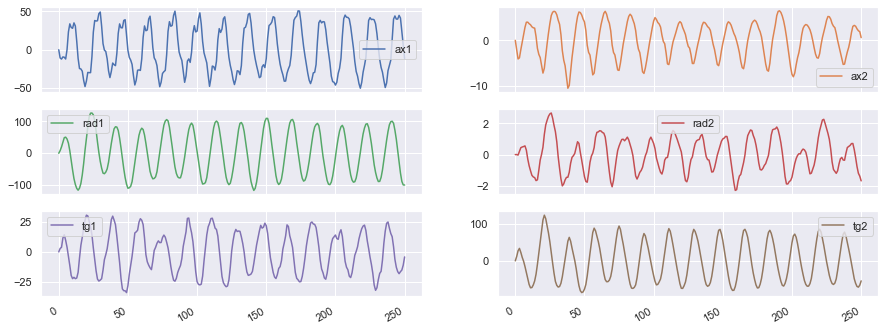

In [213]:
# velocidades FILTRADAS no tempo 
velocity_filter_before.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));
velocity_filter_after.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));

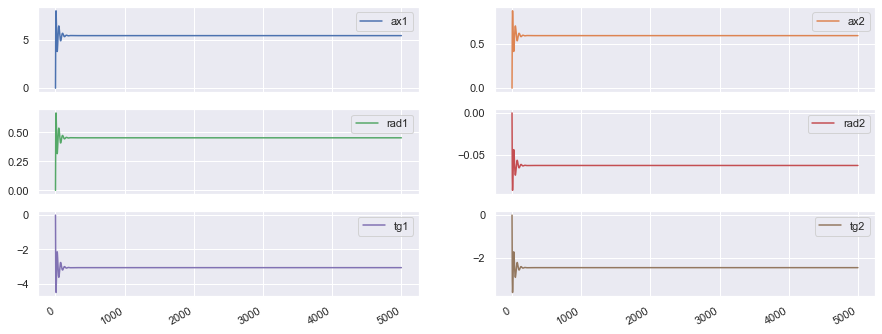

In [186]:
# diferença entre filtrar antes ou depois
velocity_filter_difference = velocity_filter_before - velocity_filter_after
velocity_filter_difference.plot(subplots=True, layout=(4,2), figsize=(15,8));

Note o offset em relação ao zero.

Há pouca diferença filtrar o sinal antes ou depois, EXCETO que filtrar depois garante a retirada de qualquer nível DC no sinal de velocidade. Verifique no espectro que não há nível DC.

In [192]:
# aplica a transformada no sinal filtrado                                     
velocity_fft = velocity_filter_after.apply(np.fft.rfft, axis=0, norm="ortho")
velocity_fft = velocity_fft.apply(np.abs)
velocity_fft['freq_ax'] = np.linspace(0, sampling_freq/2+1, signals_fft.shape[0])

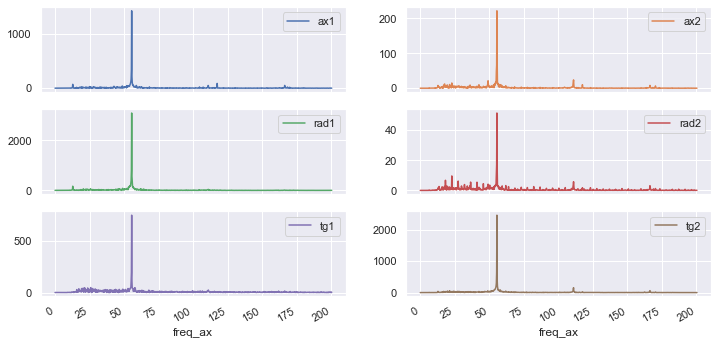

In [193]:
# velocidades na frequência
velocity_fft.loc[:1000].plot(subplots=True, x='freq_ax', layout=(4,2), figsize=(12,8))
plt.show()

Velocidade              ax1         ax2         rad1       rad2         tg1          tg2
277  1414.596659  221.984278  3088.871434  51.378489  748.434153  2460.716131

Aceleração            ax1       ax2        rad1      rad2        tg1        tg2
277  50.712762  7.959187  110.766036  1.842229  26.833181  88.222671

Plotando dados normalizados pelo maior valor em seu tipo de grandeza:


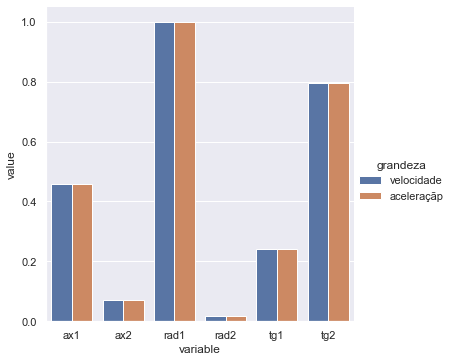

In [194]:
# faz tabulação dos valores de velocidade
vel = velocity_fft.iloc[index].drop('freq_ax', axis=1)
print('Velocidade', vel)
vel = vel/vel.max().max()
vel = vel.melt()
vel['grandeza'] = 'velocida

acc = accelerations_fft.iloc[index].drop('freq_ax', axis=1)
print('\nAceleração', acc)
acc = acc/acc.max().max()
acc = acc.melt()
acc['grandeza'] = 'aceleraçãp'

print('\nPlotando dados normalizados pelo maior valor em seu tipo de grandeza:')
sns.catplot(data=pd.concat([vel,acc]), kind='bar', x='variable', y='value', hue='grandeza');

Nota-se que os valores de pico na velocidade e na aceleração apresentam a mesma relação de grandeza entre si.

No entanto, analisando os valores RSM há pequenas variações, possivelmente devido ao filtro passa alta.

RMS velocidades: [31.076431176012854, 5.331500391682059, 67.80689479597717, 1.3115465604547722, 17.252524216363085, 53.60999937070239]
RMS acelerações: [1.4618395567370515, 0.25292235038401206, 2.519832083744101, 0.05970329752621397, 0.7472983198833273, 2.2858880240787958]
Valores de RMS:


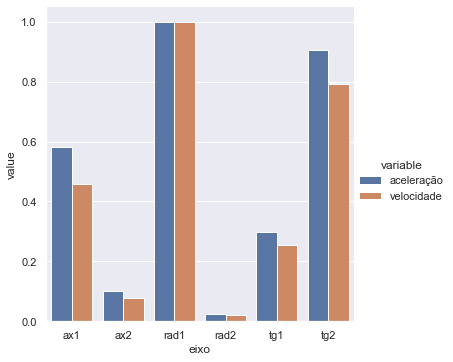

In [195]:
def rms(x):
    return np.sqrt(x.dot(x)/x.size)

rms_vel = []
for col in velocity_filter_after.columns:
    rms_vel.append( rms(np.array(velocity_filter_after[col])) )
print('RMS velocidades:', rms_vel)

rms_acc = []
for col in accelerations.columns:
    rms_acc.append( rms(np.array(accelerations[col])) )
print('RMS acelerações:', rms_acc)

RMS_values = pd.DataFrame({
    'eixo':  accelerations.columns,
    'aceleração': rms_acc/np.array(rms_acc).max(),
    'velocidade': rms_vel/np.array(rms_vel).max(),
})

print('Valores de RMS:')
sns.catplot(data = RMS_values.melt(id_vars='eixo'), kind='bar', x='eixo', y='value', hue='variable');

In [212]:
vel_rms = velocity_filter_after.apply(rms).to_dict()
vel_rms = {k+'_vel_rms':v for k, v in vel_rms.items()}
vel_rms

{'ax1_vel_rms': 31.076431176012854,
 'ax2_vel_rms': 5.331500391682059,
 'rad1_vel_rms': 67.80689479597717,
 'rad2_vel_rms': 1.3115465604547722,
 'tg1_vel_rms': 17.252524216363085,
 'tg2_vel_rms': 53.60999937070239}

## Extração ingênua dos picos na frequência
Note que há uma série de valores elevados em torno de um mesmo pico, confundindo a análise.

**Conclusão:** não há ganho de informação quando se extrai o pico da 1a harmônica do sinal da velocidade. 

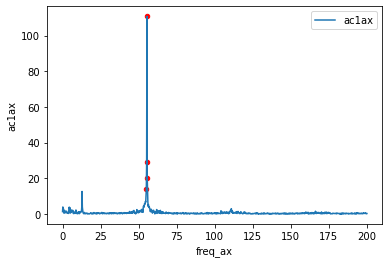

,freq_ax,ac1ax,harmonic
277,55.511,110.766,1.000
276,55.310,28.943,0.996
278,55.711,20.141,1.004
275,55.110,14.142,0.993


In [151]:
STUDY_FFT = signals_fft[['freq_ax','ac1ax']]

col_name = STUDY_FFT.columns[1]
ordered_study_fft = STUDY_FFT.sort_values(by=col_name, ascending=False) # ordenando o sinal
ordered_study_fft['n_harmonic'] = ordered_study_fft['freq_ax']/fundamental

pd.options.display.float_format = '{:,.3f}'.format


ax = signals_fft.iloc[:1000,:].plot(x='freq_ax', y=col_name)
ordered_study_fft.iloc[:4,:].plot(x='freq_ax', y=col_name, kind='scatter', color='red', ax=ax)
plt.show()

# mostra tabela
ordered_study_fft.iloc[:4,:]